In [1]:
# TODO: make plots for norman data

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import scanpy as sc
from src.utils.spectra.dataset import SpectraDataset
from src.utils.spectra.perturb import Spectra
from gears import PertData


In [8]:
class PerturbGraphData(SpectraDataset):
    def parse(self, pert_data):
        if isinstance(pert_data, PertData):
            self.adata = pert_data.adata
        else:
            self.adata = pert_data
        self.control_expression = self.adata[self.adata.obs['condition'] == 'ctrl'].X.toarray().mean(axis=0)
        return [p for p in self.adata.obs['condition'].unique() if p != 'ctrl']

    def get_mean_logfold_change(self, perturbation):
        perturbation_expression = self.adata[self.adata.obs['condition'] == perturbation].X.toarray().mean(axis=0)
        logfold_change = np.nan_to_num(np.log2(perturbation_expression + 1) - np.log2(self.control_expression + 1))
        return logfold_change

    def sample_to_index(self, sample):
        if not hasattr(self, 'index_to_sequence'):
            print("Generating index to sequence")
            self.index_to_sequence = {}
            for i in tqdm(range(len(self))):
                x = self.__getitem__(i)
                self.index_to_sequence['-'.join(list(x))] = i

        return self.index_to_sequence[sample]
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        perturbation = self.samples[idx]
        return self.get_mean_logfold_change(perturbation)

In [4]:
class SPECTRAPerturb(Spectra):
    def spectra_properties(self, sample_one, sample_two):
        return -np.linalg.norm(sample_one - sample_two)

    def cross_split_overlap(self, train, test):
        average_similarity = []

        for i in test:
            for j in train:
                average_similarity.append(self.spectra_properties(i, j))

        return np.mean(average_similarity)

In [5]:
adata = sc.read('data/norman_2019_raw.h5ad')

In [6]:
nonzero_genes = (adata.X.sum(axis=0) > 5).A1
filtered_adata = adata[:, nonzero_genes]
single_gene_mask = [True if "," not in name else False for name in adata.obs['guide_ids']]
sg_adata = filtered_adata[single_gene_mask, :]
sg_adata.obs['condition'] = sg_adata.obs['guide_ids'].replace('', 'ctrl')

genes = sg_adata.var['gene_symbols'].to_list()
genes_and_ctrl = genes + ['ctrl']

# we remove the cells with perts that are not in the genes because we need gene expression values
# to generate an in-silico perturbation embedding
sg_pert_adata = sg_adata[sg_adata.obs['condition'].isin(genes_and_ctrl), :]

In [9]:
perturb_graph_data = PerturbGraphData(sg_pert_adata, 'norman')

In [10]:
sc_spectra = SPECTRAPerturb(perturb_graph_data, binary = False)

In [11]:
sc_spectra.pre_calculate_spectra_properties('sc_norman')

File sc_norman_precalculated_spectra_properties already exists, set force_recalculate to True to recalculate


In [34]:
spectra_parameters = {'number_repeats': 3, 
                      'random_seed': [42, 44, 46],
                      'spectral_parameters': ["{:.2f}".format(i) for i in np.arange(0, 1.05, 0.05)],
                      'force_reconstruct': True,
                                              }
sc_spectra.generate_spectra_splits(**spectra_parameters)

Generating SPECTRA split for spectral parameter 0.0 and dataset norman
Number of samples in independent set: 276
Train size: 220	Test size: 56
Cross split overlap: -4.8159260749816895



Generating SPECTRA split for spectral parameter 0.0 and dataset norman
Number of samples in independent set: 276
Train size: 220	Test size: 56
Cross split overlap: -4.60251522064209



Generating SPECTRA split for spectral parameter 0.0 and dataset norman
Number of samples in independent set: 276
Train size: 220	Test size: 56
Cross split overlap: -4.512292861938477



Generating SPECTRA split for spectral parameter 0.1 and dataset norman
Number of samples in independent set: 181
Train size: 144	Test size: 37
Cross split overlap: -5.278563022613525



Generating SPECTRA split for spectral parameter 0.1 and dataset norman
Number of samples in independent set: 185
Train size: 148	Test size: 37
Cross split overlap: -5.177642822265625



Generating SPECTRA split for spectral parameter 0.1 and dataset norman

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1073c9570>>
Traceback (most recent call last):
  File "/Users/aaronw/Desktop/PhD/Research/QMUL/Research/scBench/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

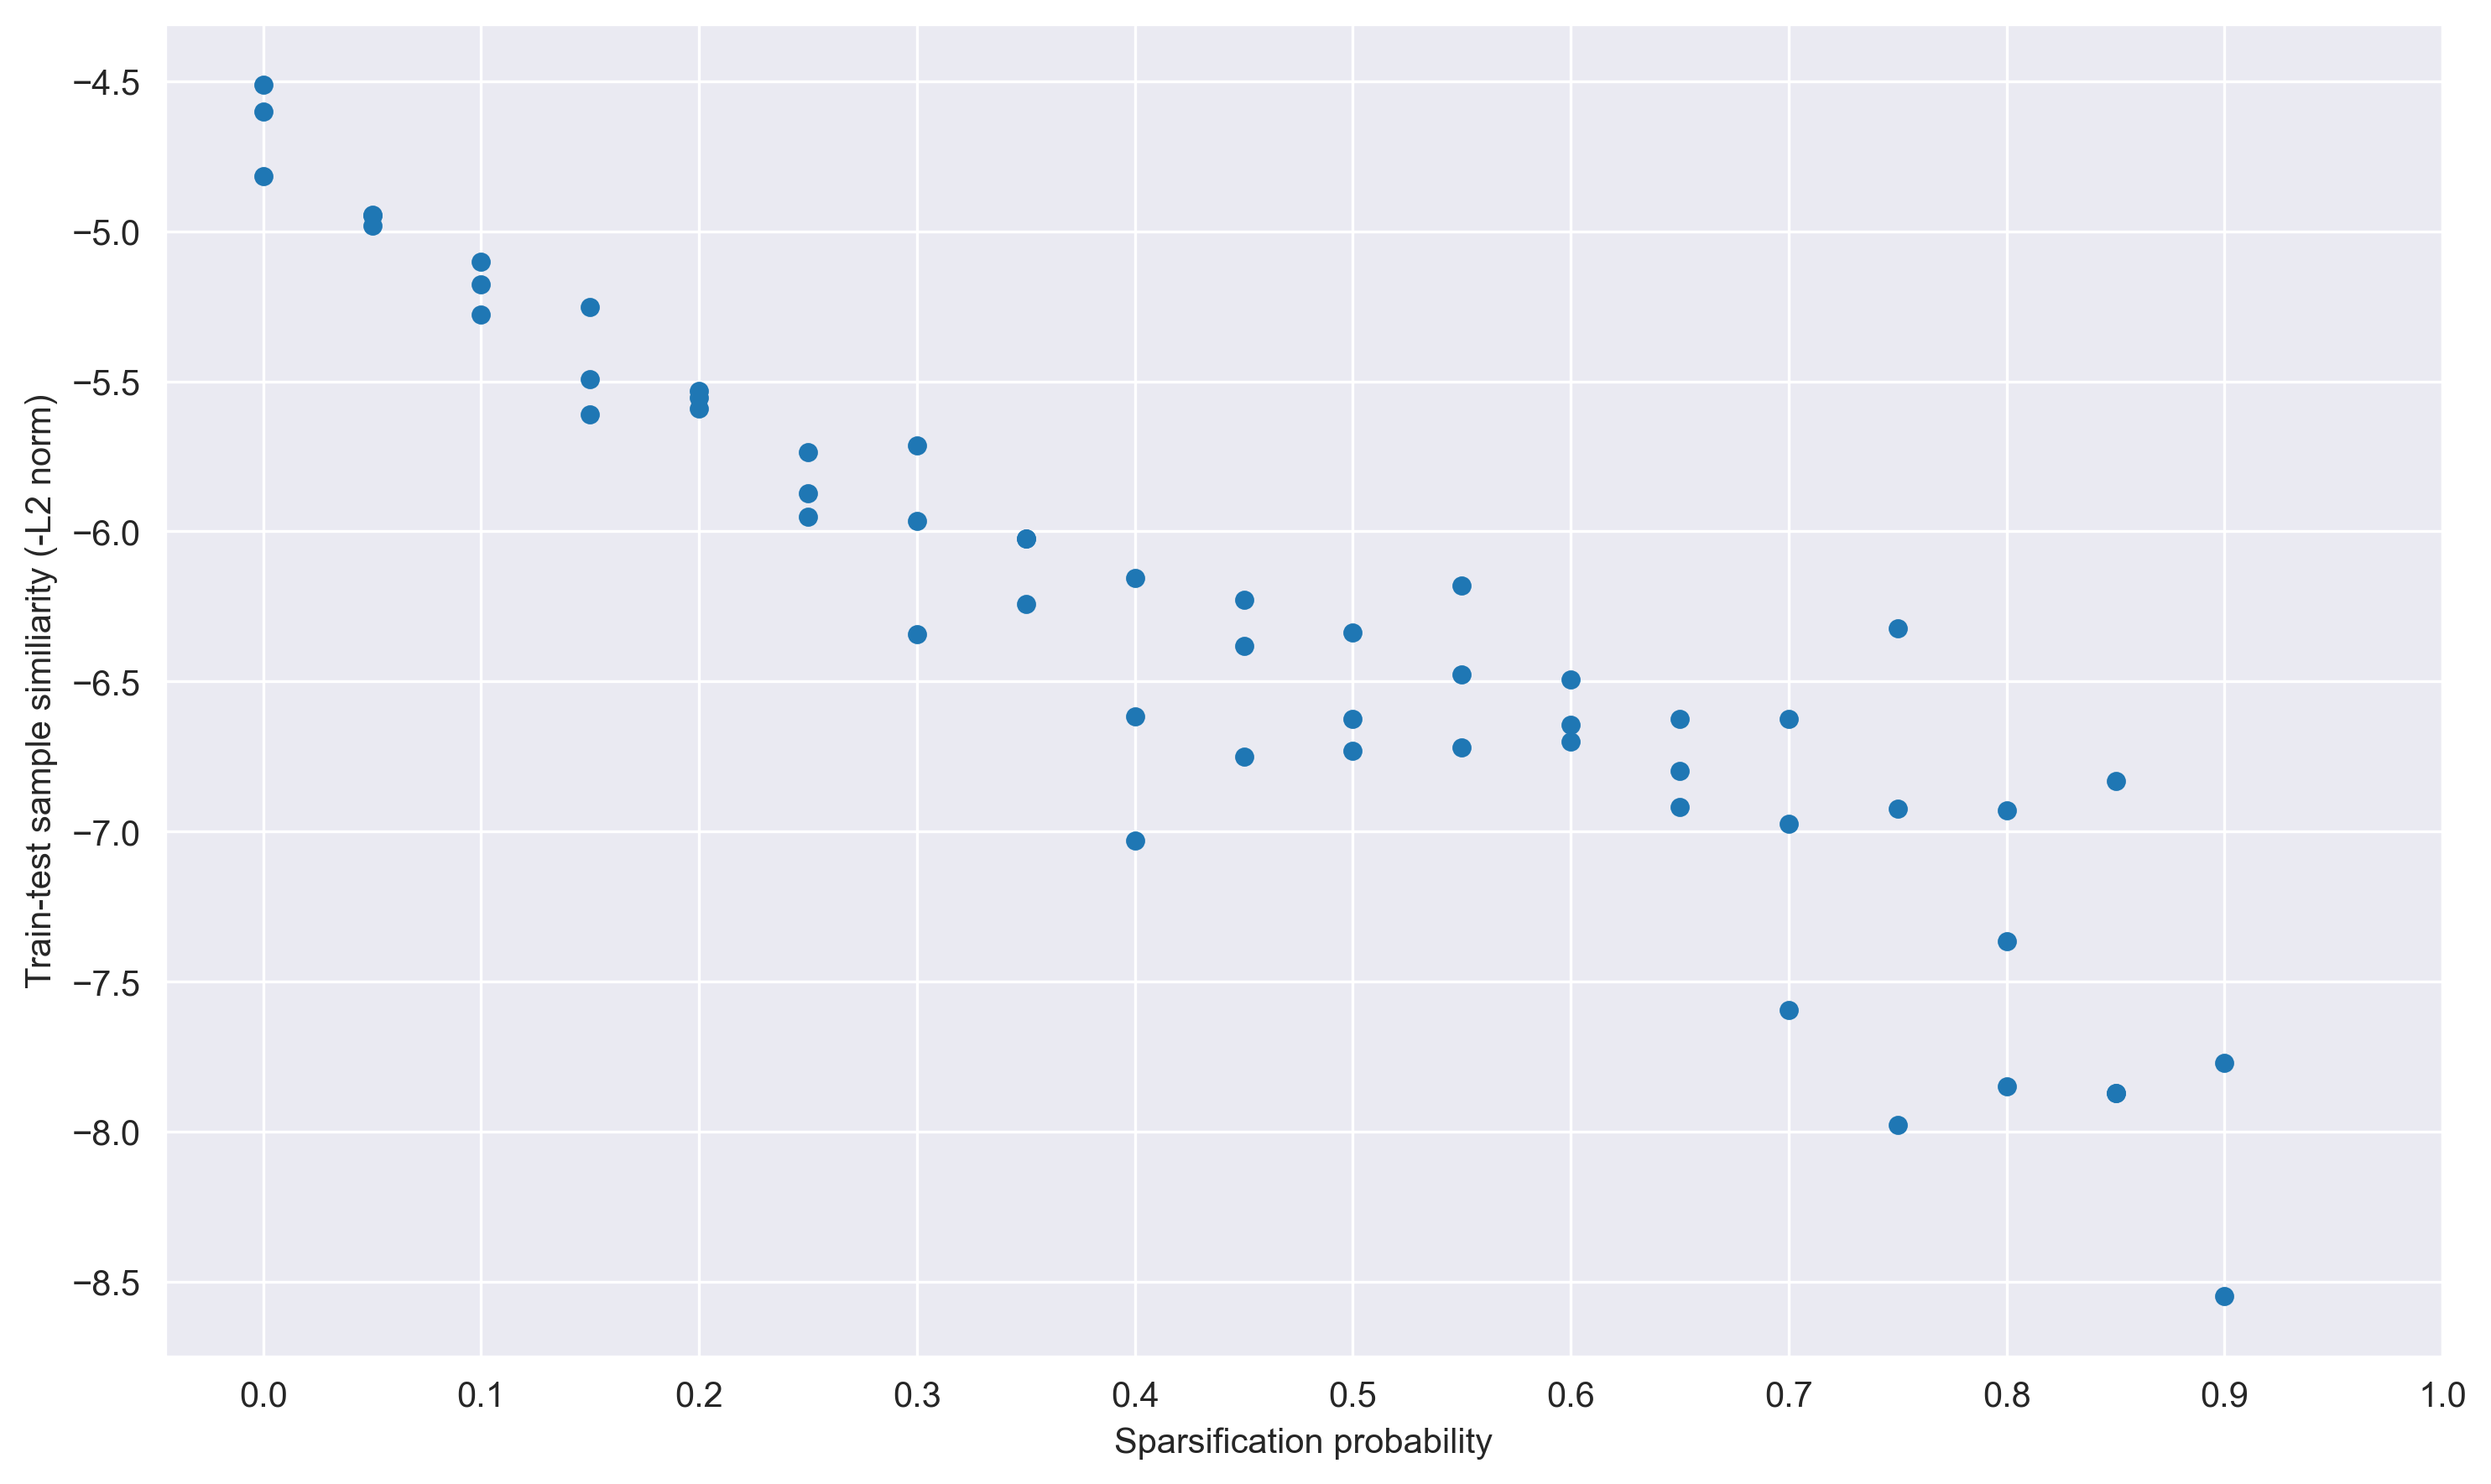

In [24]:
# set dpi to 300 

stats = sc_spectra.return_all_split_stats()
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(stats['SPECTRA_parameter'], stats['cross_split_overlap'], s=20)
# plt.plot(stats['SPECTRA_parameter'], stats['cross_split_overlap'], marker='o', linestyle='-', color='b')
plt.xlabel('Sparsification probability')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.ylabel('Train-test sample similiarity (-L2 norm)')
plt.tight_layout()
# save figure
plt.savefig('similarity_across_splits.pdf')

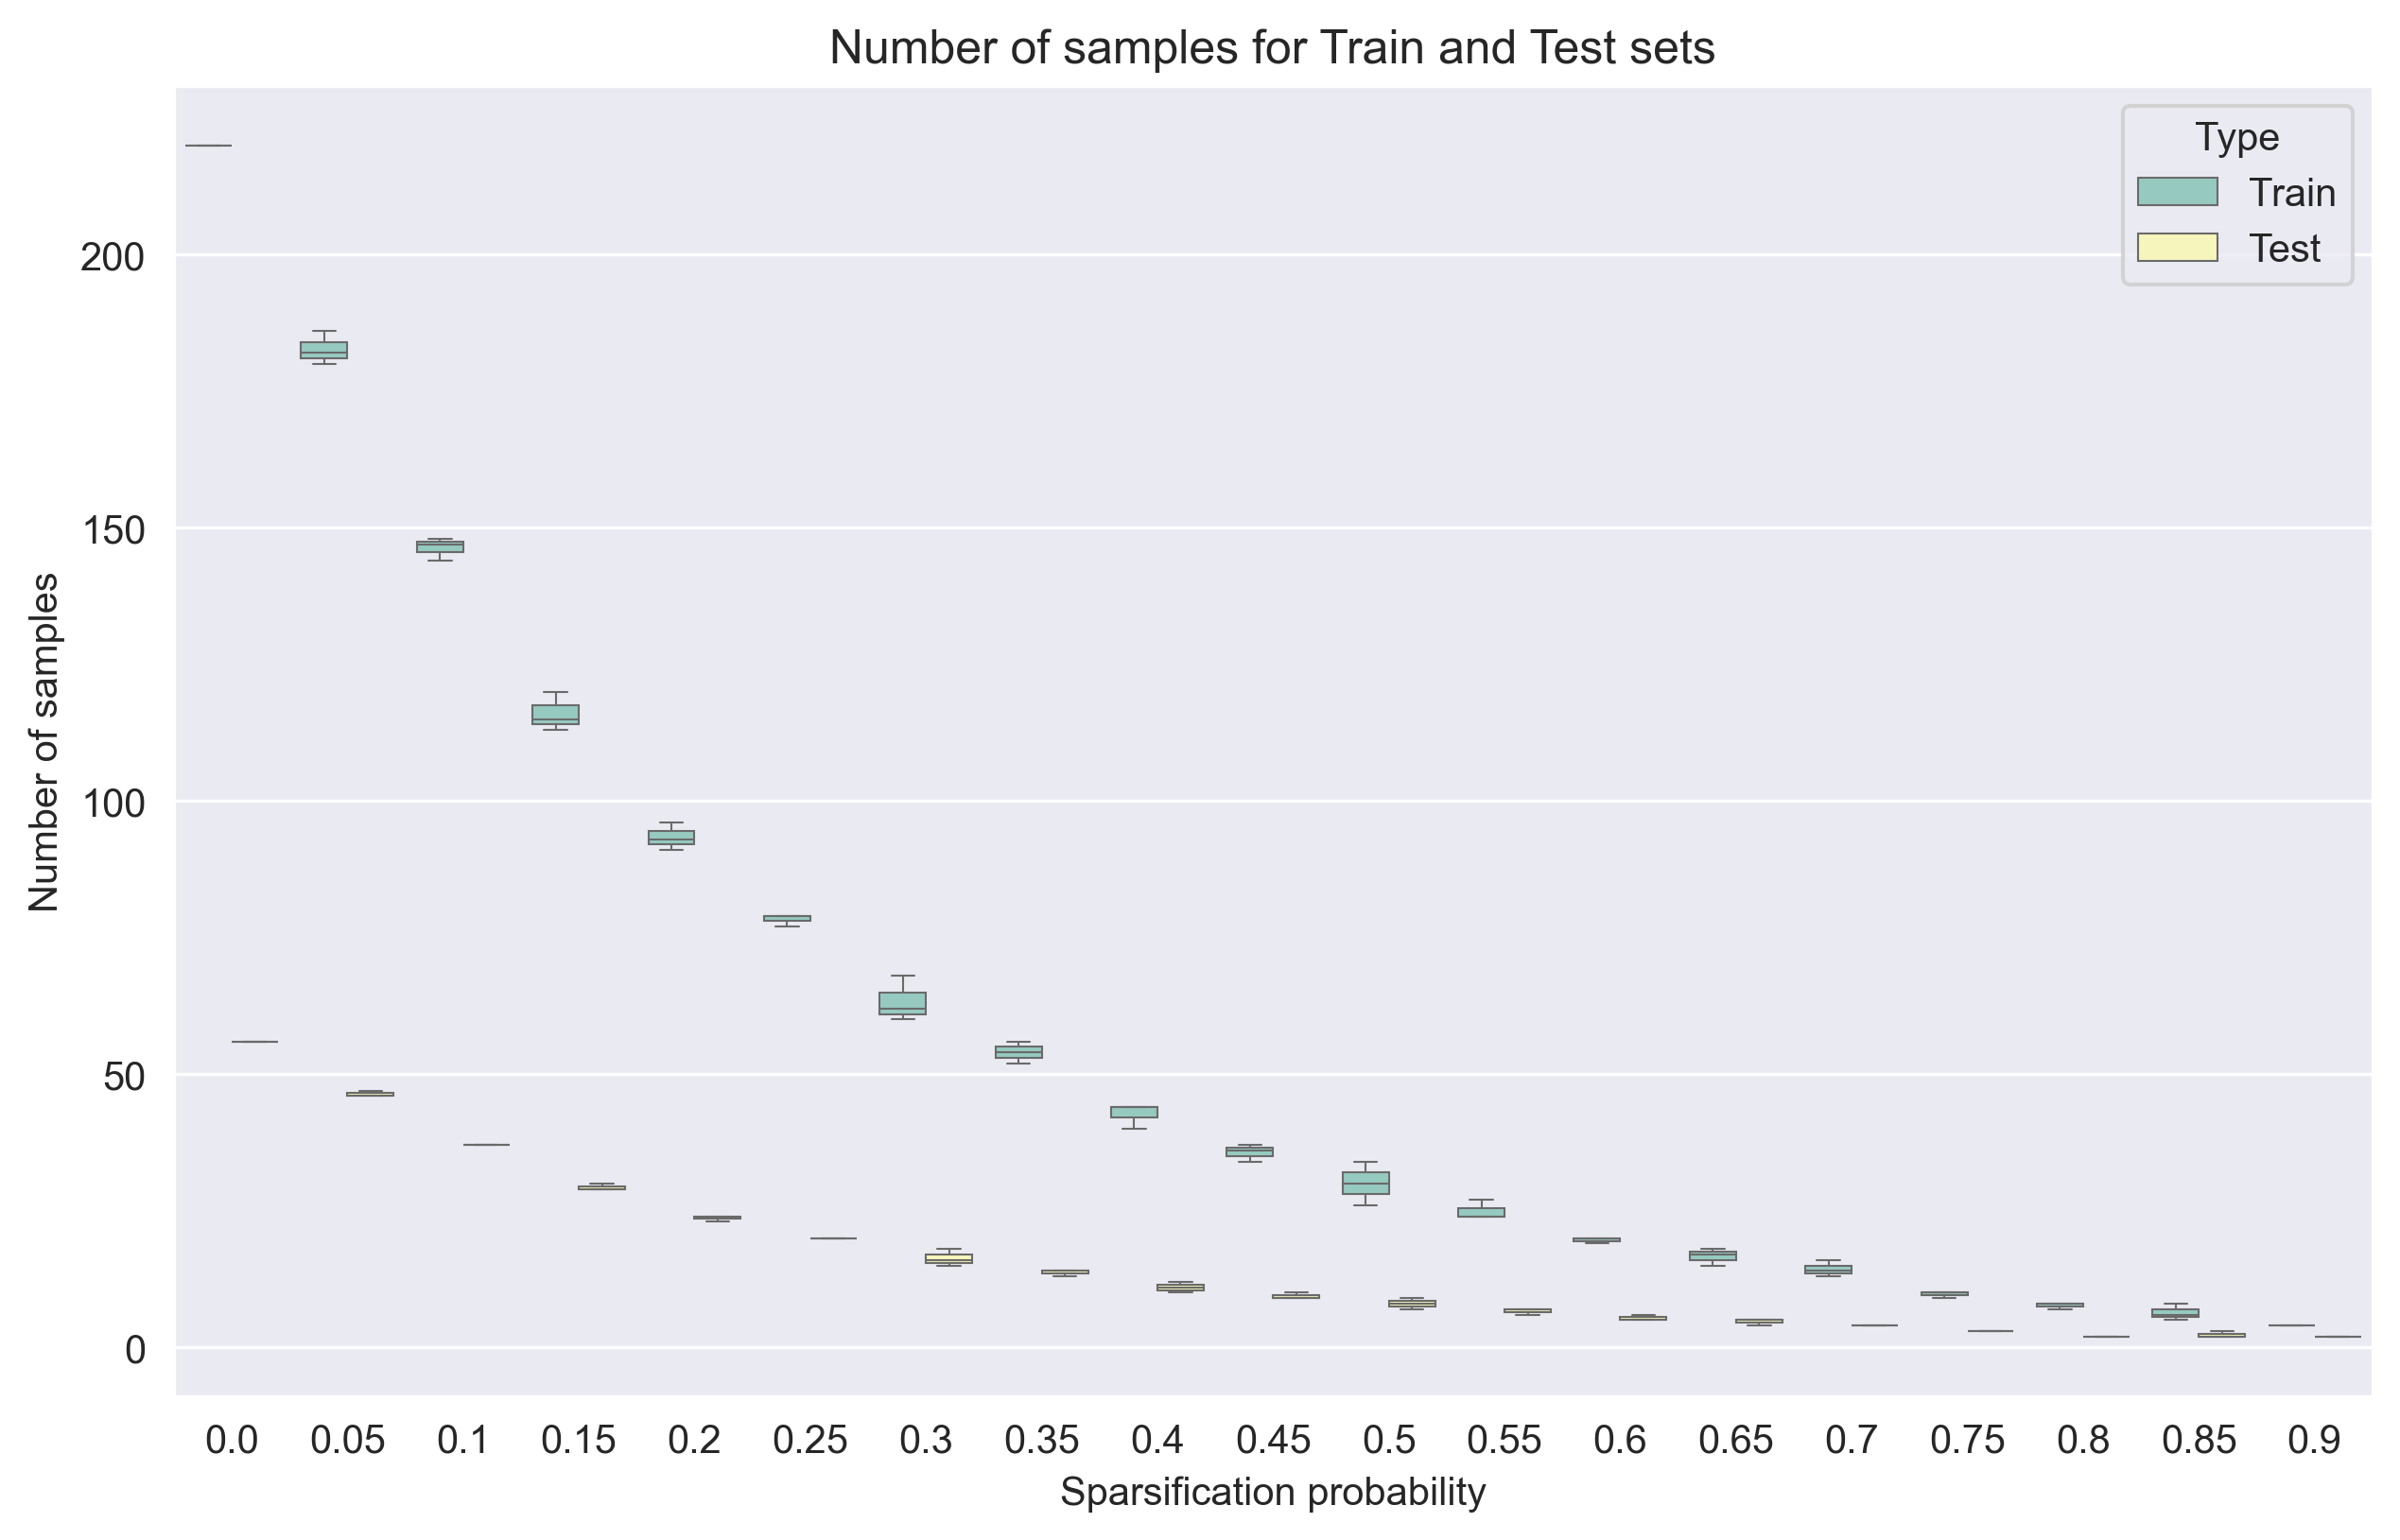

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert the data to a DataFrame for easier manipulation
df_train = pd.DataFrame({
    'SPECTRA_parameter': stats['SPECTRA_parameter'],
    'Size': stats['train_size'],
    'Type': ['Train'] * len(stats['SPECTRA_parameter'])
})

df_test = pd.DataFrame({
    'SPECTRA_parameter': stats['SPECTRA_parameter'],
    'Size': stats['test_size'],
    'Type': ['Test'] * len(stats['SPECTRA_parameter'])
})

# Concatenate the dataframes
df = pd.concat([df_train, df_test])

# Create boxplots
plt.figure(figsize=(10, 6), dpi=300)
sns.boxplot(x='SPECTRA_parameter', y='Size', hue='Type', data=df, palette="Set3", linewidth=0.5)
plt.xlabel('Sparsification probability')
plt.ylabel('Number of samples')
plt.title('Number of samples for Train and Test sets')
plt.show()

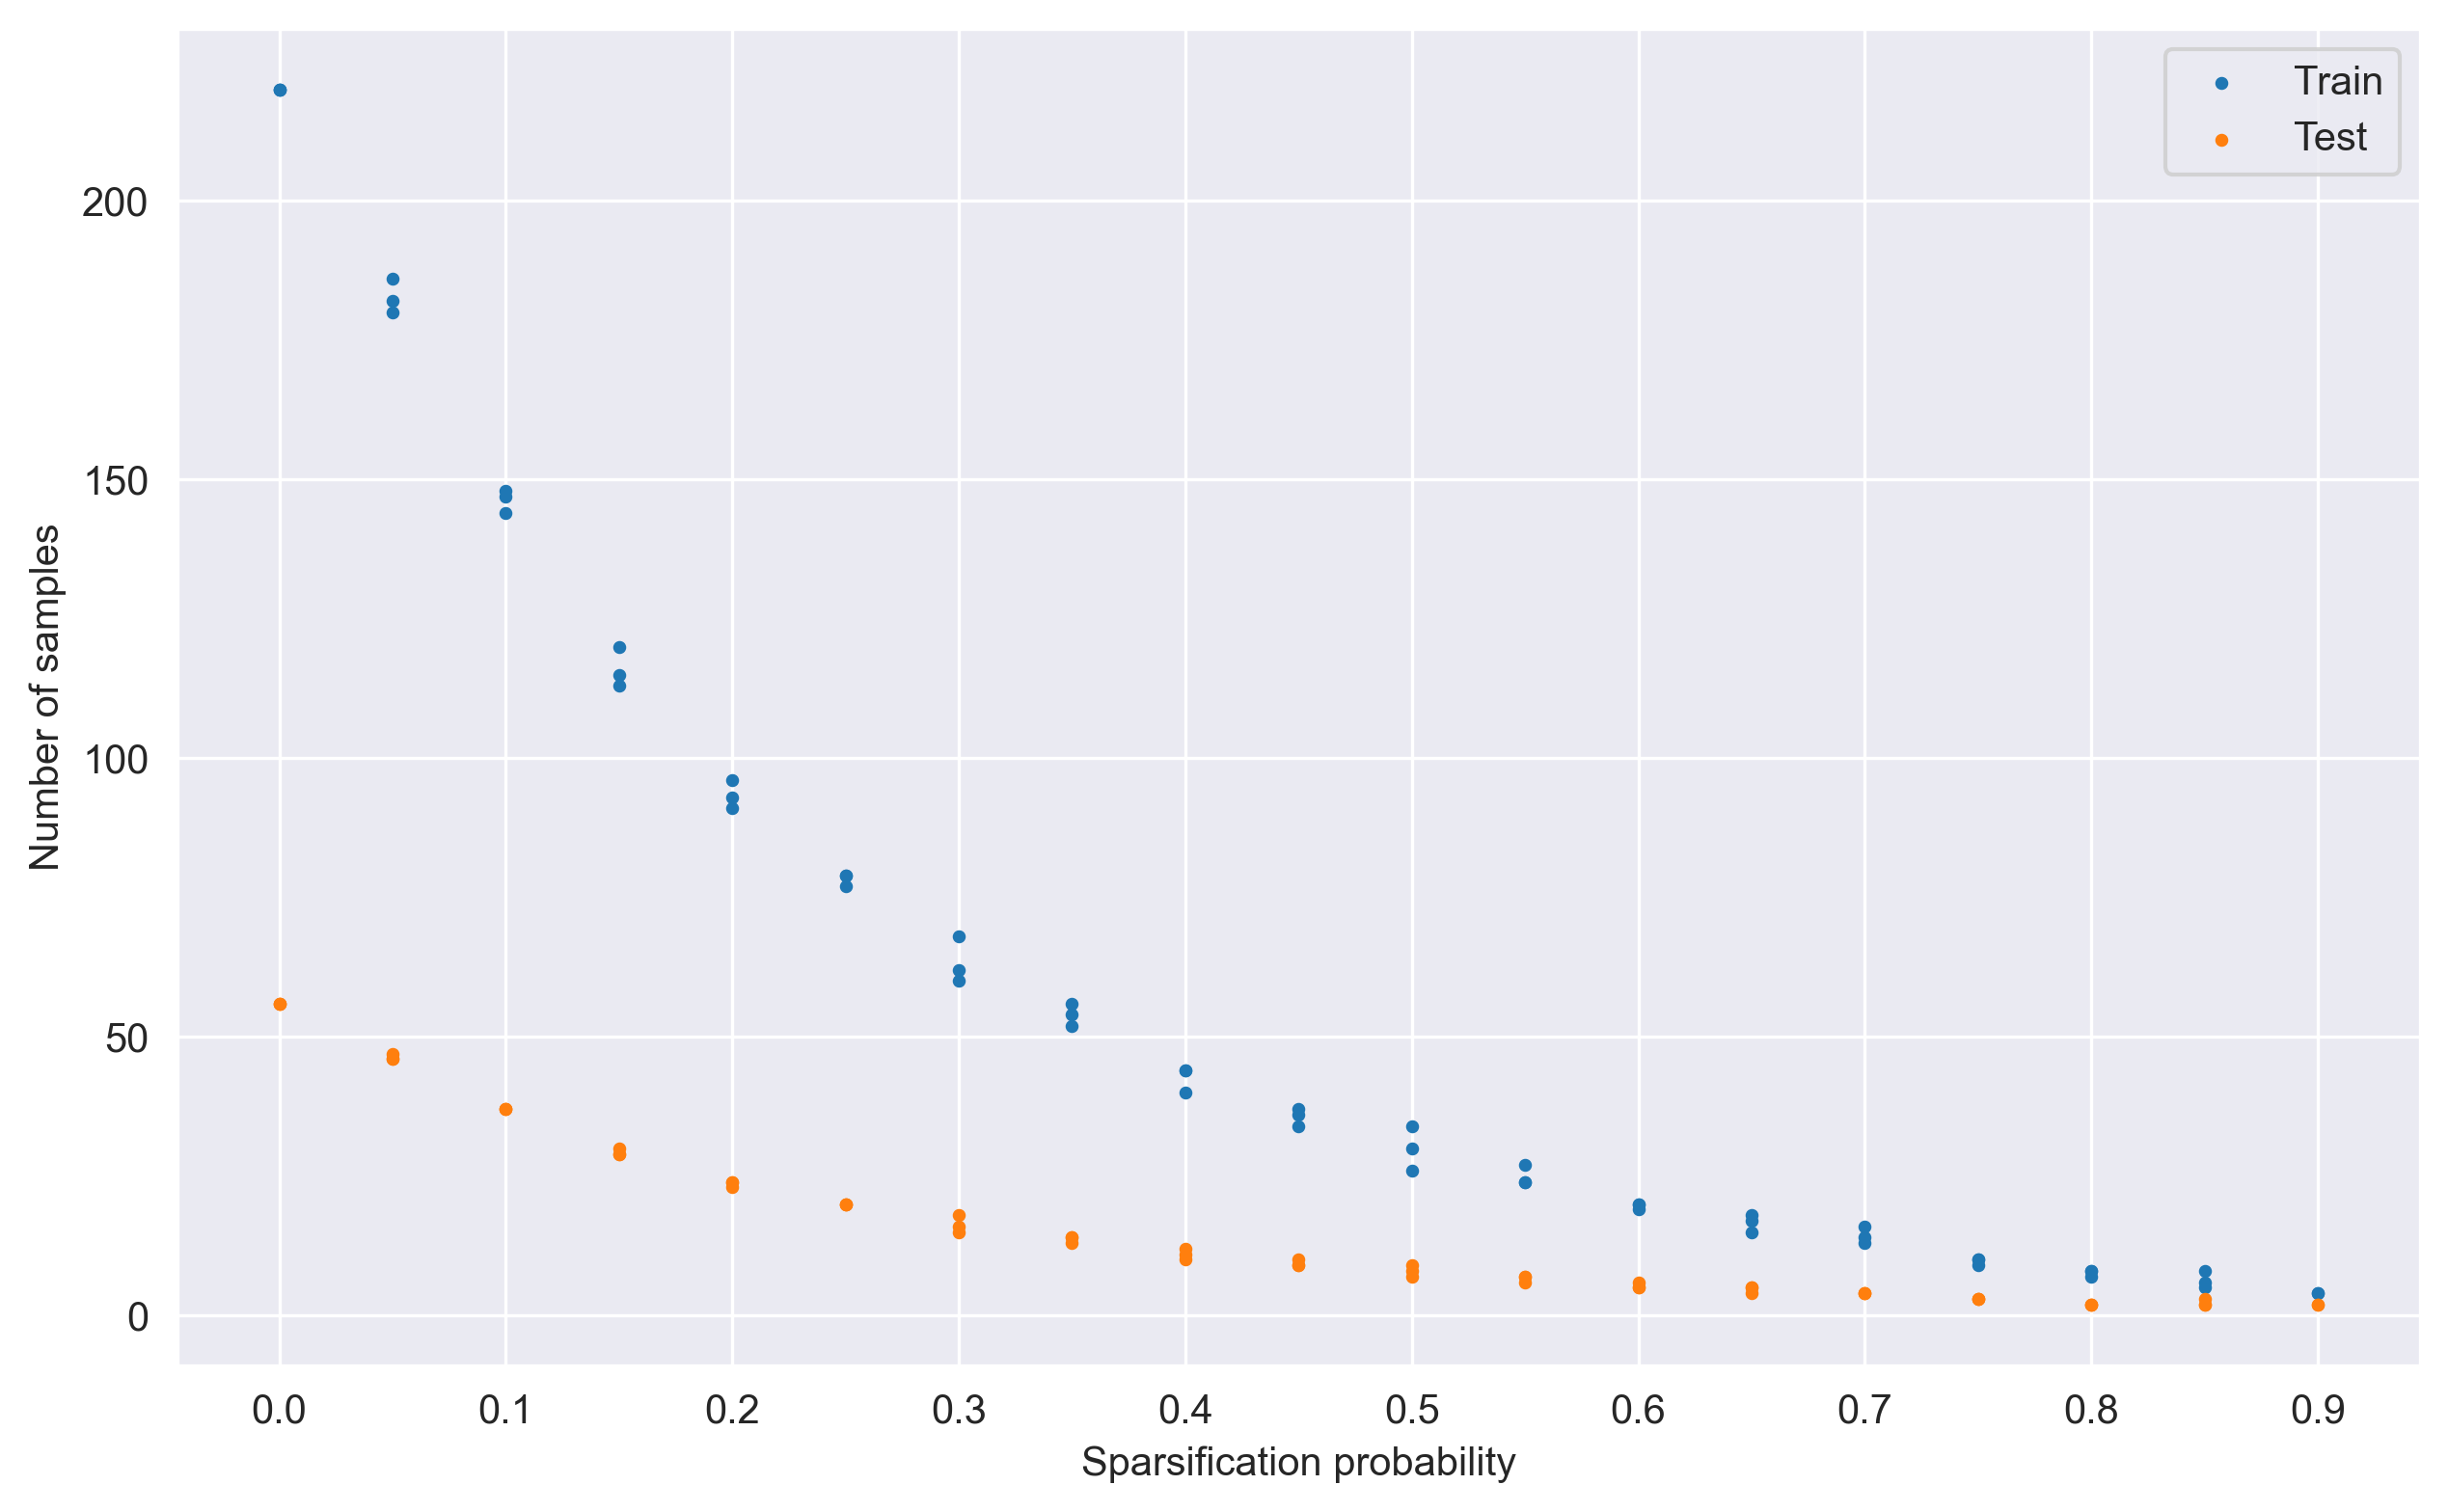

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the data to a DataFrame for easier manipulation
df_train = pd.DataFrame({
    'SPECTRA_parameter': stats['SPECTRA_parameter'],
    'Size': stats['train_size'],
    'Type': ['Train'] * len(stats['SPECTRA_parameter'])
})

df_test = pd.DataFrame({
    'SPECTRA_parameter': stats['SPECTRA_parameter'],
    'Size': stats['test_size'],
    'Type': ['Test'] * len(stats['SPECTRA_parameter'])
})

# Concatenate the dataframes
df = pd.concat([df_train, df_test])

# Create scatter plots
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(df[df['Type'] == 'Train']['SPECTRA_parameter'], df[df['Type'] == 'Train']['Size'], color='tab:blue', label='Train', s=5)
plt.scatter(df[df['Type'] == 'Test']['SPECTRA_parameter'], df[df['Type'] == 'Test']['Size'], color='tab:orange', label='Test', s=5)
plt.xticks(np.arange(0, 1, 0.1)) 
plt.xlabel('Sparsification probability')
plt.ylabel('Number of samples')
plt.legend()
plt.savefig('num_samples_across_splits_norman.pdf')

In [31]:
# todo: 1) check if perturbation list index wise is the same as the one generated in spectra 
# todo: 2) find strong perturbations in split 0.7 

In [38]:
all_perts_orig = [p for p in sg_pert_adata.obs['condition'].unique() if p != 'ctrl']

all_perts_map = {i: pert for i, pert in enumerate(all_perts_orig)}

{0: 'TSC22D1',
 1: 'MAML2',
 2: 'CEBPE',
 3: 'DUSP9',
 4: 'ELMSAN1',
 5: 'UBASH3B',
 6: 'FOXA1',
 7: 'BCORL1',
 8: 'MEIS1',
 9: 'GLB1L2',
 10: 'KLF1',
 11: 'BAK1',
 12: 'FEV',
 13: 'ATL1',
 14: 'CBL',
 15: 'ETS2',
 16: 'SET',
 17: 'TBX3',
 18: 'LHX1',
 19: 'SLC4A1',
 20: 'RREB1',
 21: 'ZNF318',
 22: 'COL2A1',
 23: 'ZBTB25',
 24: 'MAP4K5',
 25: 'SLC6A9',
 26: 'MIDN',
 27: 'DLX2',
 28: 'CBFA2T3',
 29: 'HES7',
 30: 'AHR',
 31: 'FOXO4',
 32: 'RHOXF2',
 33: 'SPI1',
 34: 'RUNX1T1',
 35: 'S1PR2',
 36: 'POU3F2',
 37: 'CNN1',
 38: 'CELF2',
 39: 'MAP2K3',
 40: 'MAP4K3',
 41: 'SAMD1',
 42: 'CDKN1A',
 43: 'PTPN1',
 44: 'TBX2',
 45: 'IER5L',
 46: 'CEBPA',
 47: 'PTPN12',
 48: 'TP73',
 49: 'MAP7D1',
 50: 'FOSB',
 51: 'MAPK1',
 52: 'IRF1',
 53: 'IKZF3',
 54: 'HOXB9',
 55: 'HOXC13',
 56: 'CKS1B',
 57: 'CLDN6',
 58: 'FOXA3',
 59: 'COL1A1',
 60: 'FOXF1',
 61: 'ZBTB1',
 62: 'PRTG',
 63: 'PLK4',
 64: 'BPGM',
 65: 'ARRDC3',
 66: 'BCL2L11',
 67: 'LYL1',
 68: 'MAP2K6',
 69: 'SGK1',
 70: 'CDKN1B',
 71: 'FOXL2'

In [54]:
# open split 0.7 in ../data/splits/perturb/norman/norman_SPECTRA_splits
import pickle as pkl
with open('../data/splits/perturb/norman/norman_SPECTRA_splits/SP_0.60_1/test.pkl', 'rb') as f:
    spectra_splits = pkl.load(f)

In [55]:
spectra_splits

[55, 59, 68]

In [56]:
pert_names = []
for split in spectra_splits:
    pert_name = all_perts_map[split]
    pert_names.append(pert_name)
pert_names

['HOXC13', 'COL1A1', 'MAP2K6']

In [ ]:
CEBPA -> replicate 0
IKZF3 -> replicate 1